<a href="https://colab.research.google.com/github/eunShim/BigDataCapstone/blob/main/bigdatacapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3241415140.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


총 시도 횟수와 평균 풀이 시간 상관계수: 0.267


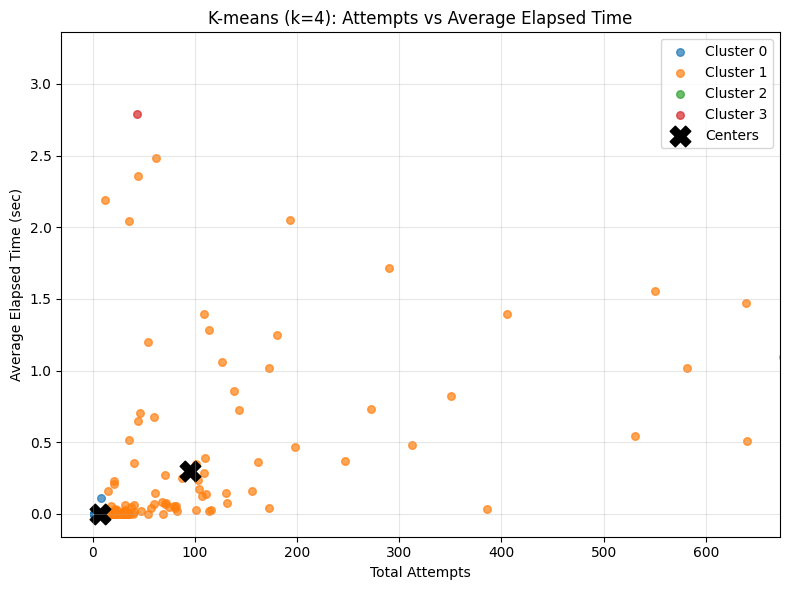

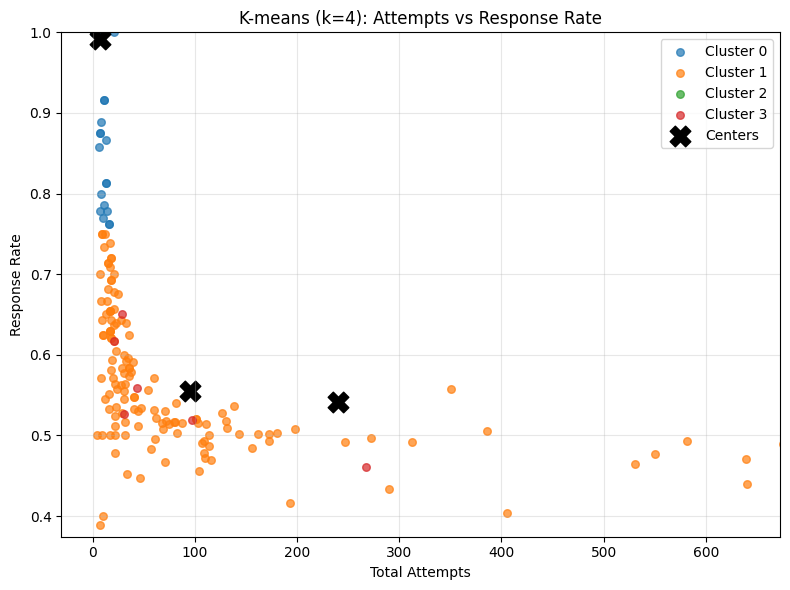

In [10]:
import zipfile
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# =======================================
# 1. ZIP에서 사용자 샘플링 (예: 500명)
# =======================================
zip_path = "/content/EdNet-KT3.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    user_files = [f for f in z.namelist() if f.startswith("KT3/") and f.endswith(".csv")]
    k = min(500, len(user_files))
    sample_files = random.sample(user_files, k)

    dfs = []
    for f in sample_files:
        with z.open(f) as fp:
            df = pd.read_csv(fp, low_memory=False)
            df["source_file"] = f.split("/")[-1].replace(".csv", "")
            dfs.append(df)

df_sample = pd.concat(dfs, ignore_index=True)

# =======================================
# 2. 사용자별 특징 추출
#    - total_attempts: submit 횟수
#    - avg_elapsed   : enter/submit 짝으로 평균 풀이시간(초)
#    - response_rate : submit/enter (0~1로 클리핑)
# =======================================
def compute_avg_elapsed(user_df):
    enter_times = user_df.loc[user_df["action_type"] == "enter", "timestamp"].reset_index(drop=True)
    submit_times = user_df.loc[user_df["action_type"] == "submit", "timestamp"].reset_index(drop=True)
    if len(enter_times) == 0 or len(submit_times) == 0:
        return np.nan
    n = min(len(enter_times), len(submit_times))
    elapsed = pd.to_datetime(submit_times[:n]) - pd.to_datetime(enter_times[:n])
    elapsed = elapsed.dt.total_seconds()
    return elapsed.mean()

user_stats = (
    df_sample.groupby("source_file")
    .apply(lambda x: pd.Series({
        "total_attempts": (x["action_type"] == "submit").sum(),
        "enter_cnt":      (x["action_type"] == "enter").sum(),
        "avg_elapsed":    compute_avg_elapsed(x)
    }))
    .reset_index()
)

# 응답률(0~1) 계산
user_stats["response_rate"] = np.where(
    user_stats["enter_cnt"] > 0,
    np.clip(user_stats["total_attempts"] / user_stats["enter_cnt"], 0, 1),
    np.nan
)

# 결측치 제거
user_stats = user_stats.dropna(subset=["avg_elapsed", "response_rate"]).reset_index(drop=True)

# =======================================
# 3. K-means 군집화 (k=4)
#    - 특성: total_attempts, avg_elapsed, response_rate
# =======================================
X = user_stats[["total_attempts", "avg_elapsed", "response_rate"]].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_stats["cluster"] = kmeans.fit_predict(X_scaled)

# 클러스터 중심(원 스케일) 계산
centers_scaled = kmeans.cluster_centers_
centers = pd.DataFrame(scaler.inverse_transform(centers_scaled),
                       columns=["total_attempts", "avg_elapsed", "response_rate"])

# =======================================
# 4. 상관관계(참고): 시도 vs 시간
# =======================================
corr = user_stats[["total_attempts", "avg_elapsed"]].corr().iloc[0, 1]
print(f"총 시도 횟수와 평균 풀이 시간 상관계수: {corr:.3f}")

# =======================================
# 5. 시각화 도우미: 축 범위를 분위수 기반으로 자동 설정
# =======================================
def auto_limits(series, q_low=1, q_high=99, pad_ratio=0.05):
    lo = np.nanpercentile(series, q_low)
    hi = np.nanpercentile(series, q_high)
    if hi == lo:
        lo = series.min()
        hi = series.max()
    pad = (hi - lo) * pad_ratio
    return lo - pad, hi + pad

# =======================================
# 6. Visualization 1: Attempts vs Avg Elapsed
# =======================================
plt.figure(figsize=(8, 6))
for c in sorted(user_stats["cluster"].unique()):
    part = user_stats[user_stats["cluster"] == c]
    plt.scatter(part["total_attempts"], part["avg_elapsed"],
                s=30, alpha=0.7, label=f"Cluster {c}")

plt.xlim(auto_limits(user_stats["total_attempts"]))
plt.ylim(auto_limits(user_stats["avg_elapsed"]))

plt.scatter(centers["total_attempts"], centers["avg_elapsed"],
            c="black", s=220, marker="X", label="Centers")

plt.xlabel("Total Attempts")
plt.ylabel("Average Elapsed Time (sec)")
plt.title("K-means (k=4): Attempts vs Average Elapsed Time")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =======================================
# 7. Visualization 2: Attempts vs Response Rate
# =======================================
plt.figure(figsize=(8, 6))
for c in sorted(user_stats["cluster"].unique()):
    part = user_stats[user_stats["cluster"] == c]
    plt.scatter(part["total_attempts"], part["response_rate"],
                s=30, alpha=0.7, label=f"Cluster {c}")

plt.xlim(auto_limits(user_stats["total_attempts"]))
ylo, yhi = auto_limits(user_stats["response_rate"])
plt.ylim((max(0.0, ylo), min(1.0, yhi)))

plt.scatter(centers["total_attempts"], centers["response_rate"],
            c="black", s=220, marker="X", label="Centers")

plt.xlabel("Total Attempts")
plt.ylabel("Response Rate")
plt.title("K-means (k=4): Attempts vs Response Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
# 클러스터별 인원수
print(user_stats["cluster"].value_counts().sort_index())

# 센트로이드(원 스케일) 요약
print(centers.round(3))  # columns: total_attempts, avg_elapsed, response_rate

# (선택) Attempts–Response Rate 상관
from scipy.stats import pearsonr, spearmanr
pr = pearsonr(user_stats["total_attempts"], user_stats["response_rate"])
sr = spearmanr(user_stats["total_attempts"], user_stats["response_rate"])
print("Pearson Attempts–ResponseRate:", pr)
print("Spearman Attempts–ResponseRate:", sr)


cluster
0    349
1    141
2      2
3      7
Name: count, dtype: int64
   total_attempts  avg_elapsed  response_rate
0           6.605        0.000          0.992
1          95.333        0.296          0.555
2        4247.500        1.578          0.483
3         240.286        4.906          0.542
Pearson Attempts–ResponseRate: PearsonRResult(statistic=np.float64(-0.287332183276586), pvalue=np.float64(6.117156866934227e-11))
Spearman Attempts–ResponseRate: SignificanceResult(statistic=np.float64(-0.7825904154460313), pvalue=np.float64(2.2883782197505152e-104))


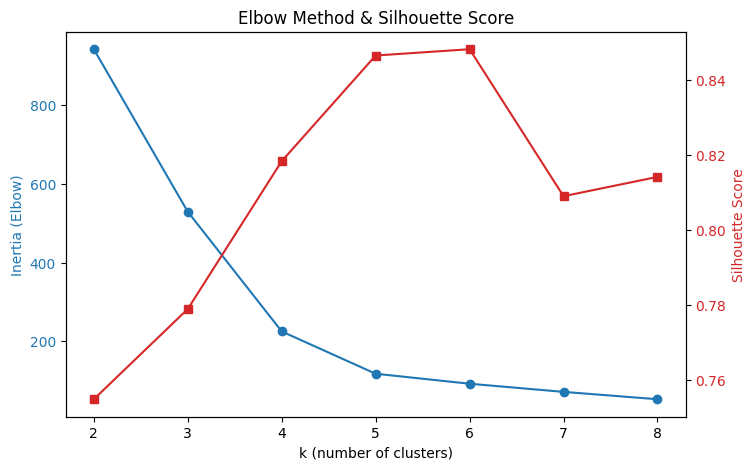

In [12]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# X_scaled는 이미 StandardScaler로 정규화된 feature 행렬이라고 가정
# (total_attempts, avg_elapsed, response_rate)

inertia = []
silhouette = []

K_range = range(2, 9)  # k=2 ~ 8

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)  # 클러스터 응집도 (작을수록 좋음)
    silhouette.append(silhouette_score(X_scaled, labels))  # -1 ~ 1, 높을수록 좋음

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(8, 5))

color = "tab:blue"
ax1.set_xlabel("k (number of clusters)")
ax1.set_ylabel("Inertia (Elbow)", color=color)
ax1.plot(K_range, inertia, marker="o", color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # 실루엣 점수는 오른쪽 y축에
color = "tab:red"
ax2.set_ylabel("Silhouette Score", color=color)
ax2.plot(K_range, silhouette, marker="s", color=color)
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Elbow Method & Silhouette Score")
plt.show()


Cluster Centers (k=3):
   total_attempts  avg_elapsed  response_rate
0        6.662890     0.000345       0.989361
1      104.701389     0.528619       0.549259
2     4247.500000     1.578335       0.483297


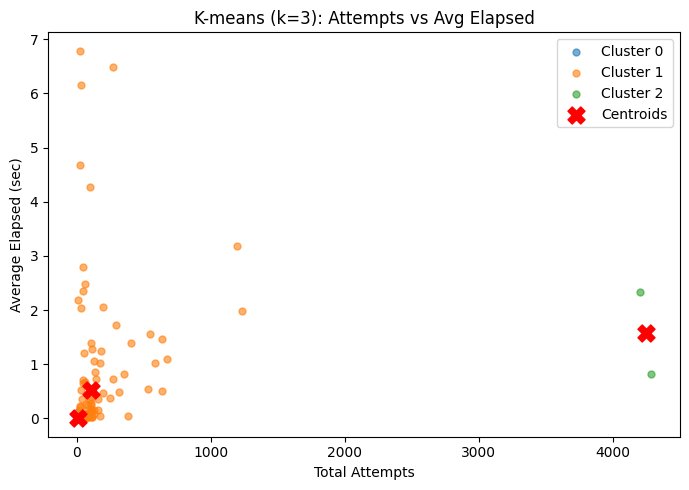

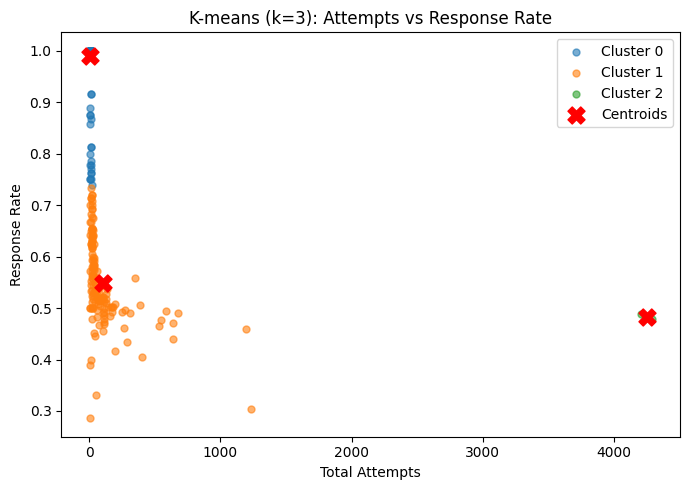

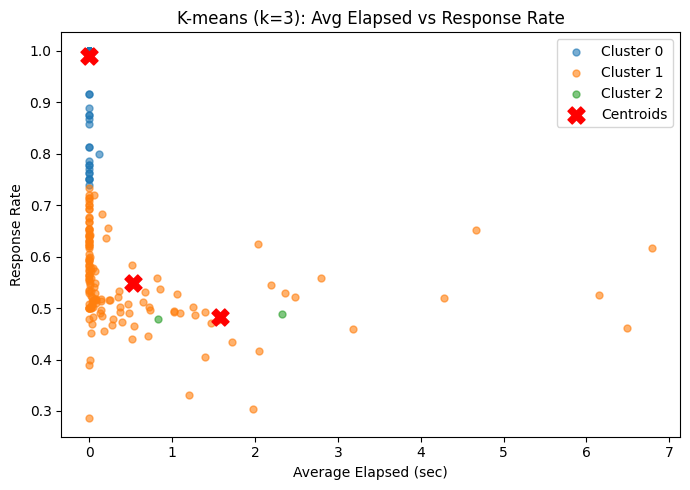

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ---------------------------------
# 1. 특징 행렬 준비
# ---------------------------------
features = ["total_attempts", "avg_elapsed", "response_rate"]
X = user_stats[features].fillna(0).values

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------
# 2. K-means (k=3)
# ---------------------------------
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
user_stats["cluster"] = kmeans.fit_predict(X_scaled)

# 클러스터 중심 (원래 스케일로 역변환)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=features)
print("Cluster Centers (k=3):")
print(centers_df)

# ---------------------------------
# 3. 시각화 1: Attempts vs Avg Elapsed
# ---------------------------------
plt.figure(figsize=(7,5))
for c in sorted(user_stats["cluster"].unique()):
    part = user_stats[user_stats["cluster"] == c]
    plt.scatter(part["total_attempts"], part["avg_elapsed"], alpha=0.6, s=25, label=f"Cluster {c}")
plt.scatter(centers[:,0], centers[:,1], c="red", marker="X", s=150, label="Centroids")
plt.title("K-means (k=3): Attempts vs Avg Elapsed")
plt.xlabel("Total Attempts")
plt.ylabel("Average Elapsed (sec)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------
# 4. 시각화 2: Attempts vs Response Rate
# ---------------------------------
plt.figure(figsize=(7,5))
for c in sorted(user_stats["cluster"].unique()):
    part = user_stats[user_stats["cluster"] == c]
    plt.scatter(part["total_attempts"], part["response_rate"], alpha=0.6, s=25, label=f"Cluster {c}")
plt.scatter(centers[:,0], centers[:,2], c="red", marker="X", s=150, label="Centroids")
plt.title("K-means (k=3): Attempts vs Response Rate")
plt.xlabel("Total Attempts")
plt.ylabel("Response Rate")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------
# 5. 시각화 3: Avg Elapsed vs Response Rate
# ---------------------------------
plt.figure(figsize=(7,5))
for c in sorted(user_stats["cluster"].unique()):
    part = user_stats[user_stats["cluster"] == c]
    plt.scatter(part["avg_elapsed"], part["response_rate"], alpha=0.6, s=25, label=f"Cluster {c}")
plt.scatter(centers[:,1], centers[:,2], c="red", marker="X", s=150, label="Centroids")
plt.title("K-means (k=3): Avg Elapsed vs Response Rate")
plt.xlabel("Average Elapsed (sec)")
plt.ylabel("Response Rate")
plt.legend()
plt.tight_layout()
plt.show()
